In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict
%matplotlib inline

### Load Data

In [2]:
demands = pd.read_excel(open('demands21.xlsx', 'rb'))
assuta_items = pd.read_excel("Assuta_items.xlsx")
refresh_21 = pd.read_excel("refresh21.xlsx")
refresh_22 = pd.read_excel("refresh22.xlsx")
initial_inventory = pd.read_excel("Initial_inventory.xls")
daily_demands_22 = pd.read_excel("daily demands 22.xlsx")
volumes = pd.read_excel("volume.xlsx")

### Pre Processing

In [3]:
# fill nulls, rename, merge, slicing

demands.fillna(0,inplace=True)

assuta_items = pd.DataFrame(assuta_items.iloc[:,0])

refresh_21.rename(columns = {f'{refresh_21.columns[0]}':'SKU_ID'}, inplace = True)
refresh_22.rename(columns = {f'{refresh_22.columns[0]}':'SKU_ID'}, inplace = True)
refresh = pd.merge(refresh_21, refresh_22, on ='SKU_ID', how ='inner')
refresh.fillna(0,inplace=True)

initial_inventory = initial_inventory.loc[:,['SKU','Total Qty']]
initial_inventory.rename(columns = {f'{initial_inventory.columns[0]}':'SKU_ID',f'{initial_inventory.columns[1]}':'Total Qty'}, inplace = True)

daily_demands_22.rename(columns = {f'{daily_demands_22.columns[0]}':'SKU_ID'}, inplace = True)
daily_demands_22.fillna(0,inplace=True)

volumes = volumes.iloc[:,:2]
volumes.rename(columns = {f'{volumes.columns[1]}':'volume'}, inplace = True)

In [4]:
# a = [i.month for i in list(refresh.iloc[:,1:].columns)]

In [5]:
# Remove assuta items from the dataframe
demands = demands[~demands["SKU_ID"].isin(assuta_items["SKU_ID"])]

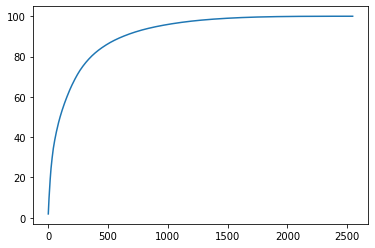

Group A includes 360 items


In [6]:
# Group A - 70% of the total demand
demands['sum_demands'] = np.sum(demands, axis=1)
demands_sum = demands.iloc[:,[0,-1]]
demands.drop(['sum_demands'], axis=1, inplace=True)
demands_sum.sort_values(by=['sum_demands'], ascending=False, inplace=True)

demands_sum['cumsum'] = demands_sum['sum_demands'].cumsum()
demands_sum['cumsum_perc'] = 100 * demands_sum['cumsum'] / demands_sum['sum_demands'].sum()

# fig = plt.figure(dpi=60, figsize=(10, 7))
plt.plot(np.arange(len(demands_sum['cumsum_perc'])),demands_sum['cumsum_perc'])
# plt.xlabel = 'Longitude'
# plt.ylabel = 'Latitude'
# plt.title('xlabels() function')
plt.show()
demands_sum['Up_To'] = demands_sum['cumsum_perc'] <= 80
good_sku_ids = demands_sum[demands_sum['Up_To']]
a_list_sku_ids = good_sku_ids['SKU_ID']
print(f'Group A includes {len(list(a_list_sku_ids))} items')

In [7]:
# Leave the SKU id's demands of group A
demands = demands[demands["SKU_ID"].isin(list(a_list_sku_ids))]

In [8]:
# Intersection of demands with all files
demands = demands[demands['SKU_ID'].isin(initial_inventory["SKU_ID"])]
demands = demands[demands['SKU_ID'].isin(daily_demands_22["SKU_ID"])]
demands = demands[demands['SKU_ID'].isin(refresh["SKU_ID"])]
demands = demands[demands['SKU_ID'].isin(volumes["SKU_ID"])]

In [9]:
# Make 3 lists - less (r<9.5), good (9.5<r>10.5), more (r>10.5) while r is the number of refreshes per month
refresh['mean'] = np.mean(refresh.iloc[:,1:].to_numpy(),axis=1)
sku_ids_0to95 = list(refresh[(refresh['mean']>=0)&(refresh['mean']<9.5)]['SKU_ID'])
sku_ids_95to105 = list(refresh[(refresh['mean']>=9.5)&(refresh['mean']<=10.5)]['SKU_ID'])
sku_ids_over105 = list(refresh[refresh['mean']>10.5]['SKU_ID'])

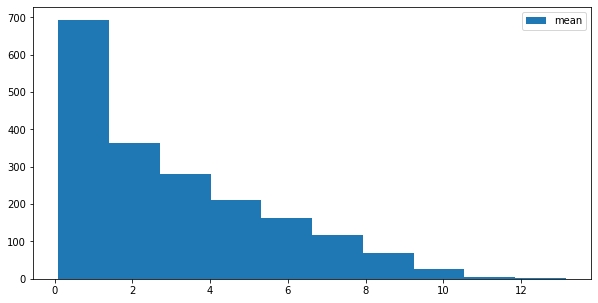

In [10]:
hist = refresh['mean'].hist(bins=10,grid=False,figsize=[10,5],legend=True)

In [11]:
lst1 = list(demands['SKU_ID'])
lst2 = sku_ids_0to95 + sku_ids_over105
relevant_sku_ids = list(set(lst1) & set(lst2)) # sku_ids of products that is not good (less or more)
print(f'The number of relevant sku_ids is: {len(relevant_sku_ids)}')

The number of relevant sku_ids is: 226


In [12]:
demands = demands[demands['SKU_ID'].isin(relevant_sku_ids)]
initial_inventory = initial_inventory[initial_inventory['SKU_ID'].isin(relevant_sku_ids)]
daily_demands_22 = daily_demands_22[daily_demands_22['SKU_ID'].isin(relevant_sku_ids)]
refresh = refresh[refresh['SKU_ID'].isin(relevant_sku_ids)]
volumes = volumes[volumes['SKU_ID'].isin(relevant_sku_ids)]


In [13]:
print(demands.shape)
demands

(226, 13)


,SKU_ID,'01','02','03','04','05','06','07','08','09','10','11','12'
12,FC038348,1874.0,1856.0,2234.0,2136.0,2126.0,2253.0,2080.0,2475.0,1929.0,2260.0,2286.0,2323.0
41,BI000161,1201.0,2345.0,527.0,758.0,1503.0,758.0,1162.0,1462.0,1844.0,1500.0,1880.0,1281.0
68,GS043189,240.0,2520.0,2112.0,12480.0,0.0,1632.0,3192.0,2592.0,1800.0,4056.0,5352.0,3936.0
71,RAK00001,2499.0,1720.0,4996.0,2305.0,3228.0,5141.0,3504.0,3714.0,2504.0,2946.0,3411.0,4773.0
78,C2241900,4477.0,4803.0,9387.0,11974.0,19149.0,14612.0,3741.0,1142.0,11069.0,5306.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2937,BI000251,11240.0,4576.0,5255.0,5701.0,3219.0,21.0,78.0,105.0,38.0,148.0,109.0,96.0
2956,ACTAV042,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9055.0,1814.0,4563.0,3408.0,4044.0
2957,2AK05630,2785.0,1210.0,1945.0,4310.0,4490.0,970.0,2137.0,1290.0,2650.0,1600.0,410.0,2615.0
2983,RB001603,0.0,1.0,53.0,106.0,90.0,10.0,61.0,2106.0,1316.0,3149.0,4723.0,5084.0


### Min Max

In [55]:
def MinMax(demands,min,max):
    copy = demands.copy()
    columns = ['SKU_ID']
    for i in range(4):
        copy['Min'+str(i+1)] = (copy.iloc[:,i*3+1:i*3+4].mean(axis=1) / 22) * min
        copy['Max'+str(i+1)] = (copy.iloc[:,i*3+1:i*3+4].mean(axis=1) / 22) * max
        columns += ['Min'+str(i+1),'Max'+str(i+1)]
    copy = copy.loc[:,columns]
    dic = defaultdict(tuple)
    for index, row in copy.iterrows():
        for i in range(1,5):
            row = list(row)
            dic[(row[0],i)] = (row[2*i-1],row[2*i])
    return dic
# minmax = MinMax(demands,3,6)

In [57]:
# minmax

### Simulation

In [58]:
# transfer 'daily_demands_22' into a dictionary structure
daily_demands_22_dic = defaultdict(list)
for index, row in daily_demands_22.iterrows():
    row = list(row)
    daily_demands_22_dic[row[0]] = row[1:]

In [59]:
# transfer 'initial_inventory' into a dictionary structure
initial_inventory_dic = defaultdict(list)
for index, row in initial_inventory.iterrows():
    row = list(row)
    initial_inventory_dic[row[0]] = row[1]

In [60]:
# transfer 'volumes' into a dictionary structure
volumes_dic = defaultdict(list)
for index, row in volumes.iterrows():
    row = list(row)
    volumes_dic[row[0]] = row[1]

In [61]:
# minmax
# a = {k:minmax[k] for k in minmax.keys() if k[1] == 4}
# a

In [20]:
def simulation (daily_demands:dict,initial_inventory:dict,volumes:dict,minmax:dict,total_high:int,total_low:int):
    days = len(daily_demands[list(daily_demands.keys())[0]])
    items = len(list(daily_demands_22_dic.keys()))
    items_sku_ids = list(daily_demands_22_dic.keys())
    refresf_dic = {item:False for item in items_sku_ids}
    current_day = 0
    current_quarter = 1
    count_refresh = 0
    OSR_volume = (total_high * 30000 + total_low * 15000) * 0.97 # leave 3% of the storage empty
    others_volume = 6450
    free_volume = OSR_volume - others_volume
    for day in range(days):
        total_volume = 0 # sum up the volums per day
        for item in items_sku_ids:
            if refresf_dic[item]:
                item_inventory = minmax[(item,current_quarter)][1] # refresh to maximum
                refresf_dic[item] = False
            item_volume = initial_inventory[item] * volumes[item]
            total_volume += item_volume
            item_inventory = initial_inventory[item] - daily_demands[item][day]
            if initial_inventory[item] < 0:
                print(f'The inventory of item {item} is less than 0 in day {current_day}')
            elif initial_inventory[item] < minmax[(item,current_quarter)][0]:
                refresf_dic[item] = True
                count_refresh += 1
            else:
                pass
        if total_volume > free_volume:
            print(f'Exceeding the OSR capacity in day {current_day}')
            return ('current_day',current_day)
        current_day += 1
        if current_day <= 89: current_quarter = 1
        elif current_day <= 180: current_quarter = 2
        elif current_day <= 272: current_quarter = 3
        else: current_quarter = 4
    return count_refresh

In [22]:
simulation(daily_demands_22_dic,initial_inventory_dic,volumes_dic,minmax,10498,2858)

16383

# Comparison

In [70]:
min_options = [3,4]
max_options = [4,5,6,8,10,12,15,18,21,24]
under_10_minmax_options = [(i,j) for i in min_options for j in max_options if j > i and j <= 5] # 3 options
under_minmax_dic = {k:MinMax(demands,k[0],k[1]) for k in under_10_minmax_options}
over_10_minmax_options = [(i,j) for i in min_options for j in max_options if j > i and j >= 6] # 16 options
over_minmax_dic = {k:MinMax(demands,k[0],k[1]) for k in over_10_minmax_options}

under_10_minmax_options = [(i,j) for i in under_10_minmax_options for j in under_10_minmax_options] # 9 (3^2) options
over_10_minmax_options = [(i,j) for i in over_10_minmax_options for j in over_10_minmax_options] # 256 (16^2) options

for under in under_10_minmax_options:
    Q1_under_minmax = under[0]
    Q2_under_minmax = under[1]
    dic1 = {k:under_minmax_dic[Q1_under_minmax][k] for k in under_minmax_dic[Q1_under_minmax].keys() if k[1] == 1}
    dic2 = {k:under_minmax_dic[Q2_under_minmax][k] for k in under_minmax_dic[Q2_under_minmax].keys() if k[1] == 2}
    merge_dic_under = dic1 | dic2
    for over in over_10_minmax_options:
        Q1_over_minmax = over[0]
        Q2_over_minmax = over[1]
        dic3 = {k:over_minmax_dic[Q1_over_minmax][k] for k in over_minmax_dic[Q1_over_minmax].keys() if k[1] == 1}
        dic4 = {k:over_minmax_dic[Q2_over_minmax][k] for k in over_minmax_dic[Q2_over_minmax].keys() if k[1] == 2}
        merge_dic_over = dic3 | dic4
        # לסנן מכל מילון את הפריטים הרלוונטיים
        merge_dic = 


Q1_over_minmax,Q2_over_minmax,merge_dic_over


# minmax
# a = {k:minmax[k] for k in minmax.keys() if k[1] == 4}
# a        


# sku_ids_0to95 = list(refresh[(refresh['mean']>=0)&(refresh['mean']<9.5)]['SKU_ID'])
# sku_ids_95to105 = list(refresh[(refresh['mean']>=9.5)&(refresh['mean']<=10.5)]['SKU_ID'])
# sku_ids_over105 = list(refresh[refresh['mean']>10.5]['SKU_ID'])

((4, 24),
 (4, 24),
 {('FC038348', 1): (361.45454545454544, 2168.7272727272725),
  ('BI000161', 1): (246.84848484848487, 1481.0909090909092),
  ('GS043189', 1): (295.27272727272725, 1771.6363636363635),
  ('RAK00001', 1): (558.4848484848485, 3350.909090909091),
  ('C2241900', 1): (1131.3333333333333, 6788.0),
  ('GS446242', 1): (363.6363636363636, 2181.818181818182),
  ('MP448707', 1): (663.6969696969697, 3982.1818181818185),
  ('DS626492', 1): (437.1515151515152, 2622.909090909091),
  ('FC082511', 1): (321.21212121212125, 1927.2727272727275),
  ('I1325633', 1): (542.5454545454545, 3255.272727272727),
  ('DSN26997', 1): (178.1818181818182, 1069.090909090909),
  ('DS626249', 1): (443.6363636363636, 2661.818181818182),
  ('MP573178', 1): (232.24242424242422, 1393.4545454545453),
  ('BI000133', 1): (649.8181818181819, 3898.909090909091),
  ('NCH63598', 1): (357.8181818181818, 2146.909090909091),
  ('MP107310', 1): (356.54545454545456, 2139.2727272727275),
  ('MP107464', 1): (244.121212121

### ------------------------

### Finish

### ------------------------

In [ ]:
# Add quarters columns
total_demands["P1"] = total_demands["'01'"] + total_demands["'02'"]
total_demands["P2"] = total_demands["'03'"] + total_demands["'04'"]
total_demands["P3"] = total_demands["'05'"] + total_demands["'06'"]
total_demands["P4"] = total_demands["'07'"] + total_demands["'08'"]
total_demands["P5"] = total_demands["'09'"] + total_demands["'10'"]
total_demands["P6"] = total_demands["'11'"] + total_demands["'12'"]

# Add quarters columns
total_demands["Q1"] = total_demands["'01'"] + total_demands["'02'"] + total_demands["'03'"]
total_demands["Q2"] = total_demands["'04'"] + total_demands["'05'"] + total_demands["'06'"]
total_demands["Q3"] = total_demands["'07'"] + total_demands["'08'"] + total_demands["'09'"]
total_demands["Q4"] = total_demands["'10'"] + total_demands["'11'"] + total_demands["'12'"]

In [ ]:
total_demands

In [ ]:
# total_demands['demand_mean'] = np.mean(total_demands.iloc[:,1:13].to_numpy(),axis=1)
# total_demands['demand_stdv'] = np.std(total_demands.iloc[:,1:13].to_numpy(),axis=1)

In [ ]:
# Make 3 lists - less (r<9.5), good (9.5<r>10.5), more (r>10.5) while r is the number of refreshes per month
refresh = pd.read_csv('refresh.csv')
refresh = refresh.iloc[:-1,:] # Remove the last row ('sum' per month)
refresh.fillna(0,inplace=True)
refresh['mean'] = np.mean(refresh.iloc[:,1:].to_numpy(),axis=1)
sku_ids_0to95 = list(refresh[(refresh['mean']>=0)&(refresh['mean']<9.5)]['SKU_ID'])
sku_ids_95to105 = list(refresh[(refresh['mean']>=9.5)&(refresh['mean']<=10.5)]['SKU_ID'])
sku_ids_over105 = list(refresh[refresh['mean']>10.5]['SKU_ID'])

In [ ]:
hist = refresh['mean'].hist(bins=10,grid=False,figsize=[10,5],legend=True)

In [ ]:
lst1 = list(total_demands['SKU_ID'])
lst2 = sku_ids_0to95 + sku_ids_over105
relevant_sku_ids = list(set(lst1) & set(lst2)) # sku_ids of products that is not good (less or more)
print(f'The number of relevant sku_ids is: {len(relevant_sku_ids)}')

In [ ]:
# Stay with only the relevant products
total_demands = total_demands[total_demands['SKU_ID'].isin(relevant_sku_ids)]
total_demands

### MinMax

In [ ]:
data = total_demands.copy().iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,12,18]]
data.replace(0.1,0,inplace=True)
data

In [ ]:
# data[data.SKU_ID=='ULM00180']

In [ ]:
# Add quarters columns
data["Q1"] = (data["'01'"] + data["'02'"] + data["'03'"]) / 3
data["Q2"] = (data["'04'"] + data["'05'"] + data["'06'"]) / 3
data["Q3"] = (data["'07'"] + data["'08'"] + data["'09'"]) / 3
data["Q4"] = (data["'10'"] + data["'11'"] + data["'12'"]) / 3

In [ ]:
# data[data.SKU_ID=='ULM00180']

In [ ]:
data_Qs = data.iloc[:,data.columns.isin(['SKU_ID','Q1','Q2','Q3','Q4','YEAR'])]
data_Qs.reset_index(inplace=True,drop=True)
data_Qs

In [ ]:
# data_Qs[data_Qs.SKU_ID=='ULM00180']